In [1]:
from finches import epsilon_calculation
from finches import epsilon_stateless
from finches.frontend.mpipi_frontend import Mpipi_frontend
from finches.frontend.calvados_frontend import CALVADOS_frontend
from matplotlib import pyplot as plt
from finches.data.forcefield_dependencies import get_null_interaction_baseline
from sparrow.data.amino_acids import VALID_AMINO_ACIDS

#
from finches import epsilon_to_FHtheory

# get for charge calibration
from finches.data.reference_sequence_info import DAS_KAPPA_RG_MPIPI

# for nice visualization of proteins
from sparrow import Protein

mf_nosalt = Mpipi_frontend(salt=0.0)
cf_nosalt = CALVADOS_frontend(salt=0.0)

mf = Mpipi_frontend()
cf = CALVADOS_frontend()

X_model_mf_nosalt = mf_nosalt.IMC_object
X_model_cf_nosalt = cf_nosalt.IMC_object

X_model_mf = mf.IMC_object
X_model_cf = cf.IMC_object



/Users/alex/Dropbox/WASHU/Holehouse/tools/finches/finches/finches/forcefields/calvados.py:235: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.038286503882254706' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  r.loc['H','q'] = 1. / ( 1 + 10**(self.pH-6) )
/Users/alex/Dropbox/WASHU/Holehouse/tools/finches/finches/finches/forcefields/calvados.py:235: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.038286503882254706' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  r.loc['H','q'] = 1. / ( 1 + 10**(self.pH-6) )


### Compute null baseline
Null baseline based on raw epsilon obtained for a GS homopolymer

In [2]:
print(f"CALVDADOS null baseline: {get_null_interaction_baseline(cf.IMC_object)}")
print(f"Mpipi null baseline: {get_null_interaction_baseline(mf.IMC_object)}")

# 
print('--> NB: we include a small augmentation to CALVADOS baseline to -0.45 instead of 0.47857041902391906')

CALVDADOS null baseline: -0.47857041902391906
Mpipi null baseline: -0.12853281852975051
--> NB: we include a small augmentation to CALVADOS baseline to -0.45 instead of 0.47857041902391906


In [3]:
# extract das-pappu sequence
seqs = [i[0] for i in DAS_KAPPA_RG_MPIPI]
k = [i[2] for i in DAS_KAPPA_RG_MPIPI]
rg = [i[1] for i in DAS_KAPPA_RG_MPIPI]
seq2sv = {}
for idx, s in enumerate(seqs):
    seq2sv[s] = f'sv{idx+1}'

names = list(seq2sv.values())    

In [5]:
seq2sv

{'EKEKEKEKEKEKEKEKEKEKEKEKEKEKEKEKEKEKEKEKEKEKEKEKEK': 'sv1',
 'EEEKKKEEEKKKEEEKKKEEEKKKEEEKKKEEEKKKEEEKKKEEEKKKEK': 'sv2',
 'KEKKKEKKEEKKEEKEKEKEKEEKKKEEKEKEKEKKKEEKEKEEKKEEEE': 'sv3',
 'KEKEEKEKKKEEEEKEKKKKEEKEKEKEKEEKKEEKKKKEEKEEKEKEKE': 'sv4',
 'KEKEKKEEKEKKEEEKKEKEKEKKKEEKKKEEKEEKKEEKKKEEKEEEKE': 'sv5',
 'EEEKKEKKEEKEEKKEKKEKEEEKKKEKEEKKEEEKKKEKEEEEKKKKEK': 'sv6',
 'EEEEKKKKEEEEKKKKEEEEKKKKEEEEKKKKEEEEKKKKEEEEKKKKEK': 'sv7',
 'KKKKEEEEKKKKEEEEKKKKEEEEKKKKEEEEKKKKEEEEKKKKEEEEKE': 'sv8',
 'EEKKEEEKEKEKEEEEEKKEKKEKKEKKKEEKEKEKKKEKKKKEKEEEKE': 'sv9',
 'EKKKKKKEEKKKEEEEEKKKEEEKKKEKKEEKEKEEKEKKEKKEEKEEEE': 'sv10',
 'EKEKKKKKEEEKKEKEEEEKEEEEKKKKKEKEEEKEEKKEEKEKKKEEKK': 'sv11',
 'EKKEEEEEEKEKKEEEEKEKEKKEKEEKEKKEKKKEKKEEEKEKKKKEKK': 'sv12',
 'KEKKKEKEKKEKKKEEEKKKEEEKEKKKEEKKEKKEKKEEEEEEEKEEKE': 'sv13',
 'EKKEKEEKEEEEKKKKKEEKEKKEKKKKEKKKKKEEEEEEKEEKEKEKEE': 'sv14',
 'KKEKKEKKKEKKEKKEEEKEKEKKEKKKKEKEKKEEEEEEEEKEEKKEEE': 'sv15',
 'EKEKEEKKKEEKKKKEKKEKEEKKEKEKEKKEEEEEEEEEKEKKEKKKKE': 'sv16',
 

In [6]:
# print kappa sequences with their epsilon values
for idx, s in enumerate(seqs):

    print(names[idx])
    print(epsilon_stateless.get_sequence_epsilon_value(s, s,  X=X_model_mf_nosalt))
    Protein(s).show_sequence()
    
    print('')

sv1
-6.40989579443891



sv2
-9.662916948329894



sv3
8.35522218571549



sv4
8.749482894443616



sv5
6.236992769965042



sv6
2.7281139173460645



sv7
-14.316770240785928



sv8
-14.319046258361567



sv9
6.669853632044436



sv10
-0.3848192151757246



sv11
1.4241628322527333



sv12
6.027843054960016



sv13
3.669531370826377



sv14
3.268594525047064



sv15
4.067597165786651



sv16
5.256218559825641



sv17
5.373626082002971



sv18
-5.769101949122131



sv19
-21.798751340711306



sv20
-2.023194155906566



sv21
-5.916136753429782



sv22
-2.4964315927342398



sv23
-5.680491904177671



sv24
-16.515051043407283



sv25
-10.215389660081172



sv26
-15.57343827795222



sv27
-18.17946734383861



sv28
-24.15613916555418



sv29
-31.497896582121683



sv30
-39.625670011784365


### First confirm the charge prefactor for Mpipi
We define this as 0.2 which scales the patterning-dependent epsilon values to be in line with anticipated ranges. Note if we think we're understating attractive charge interactions, we can scale this up further, but this seems to be a reasonable sweet spot until we can justify a more complex local charge model which would presumably require explicit charge regulation as per Fossat et al.

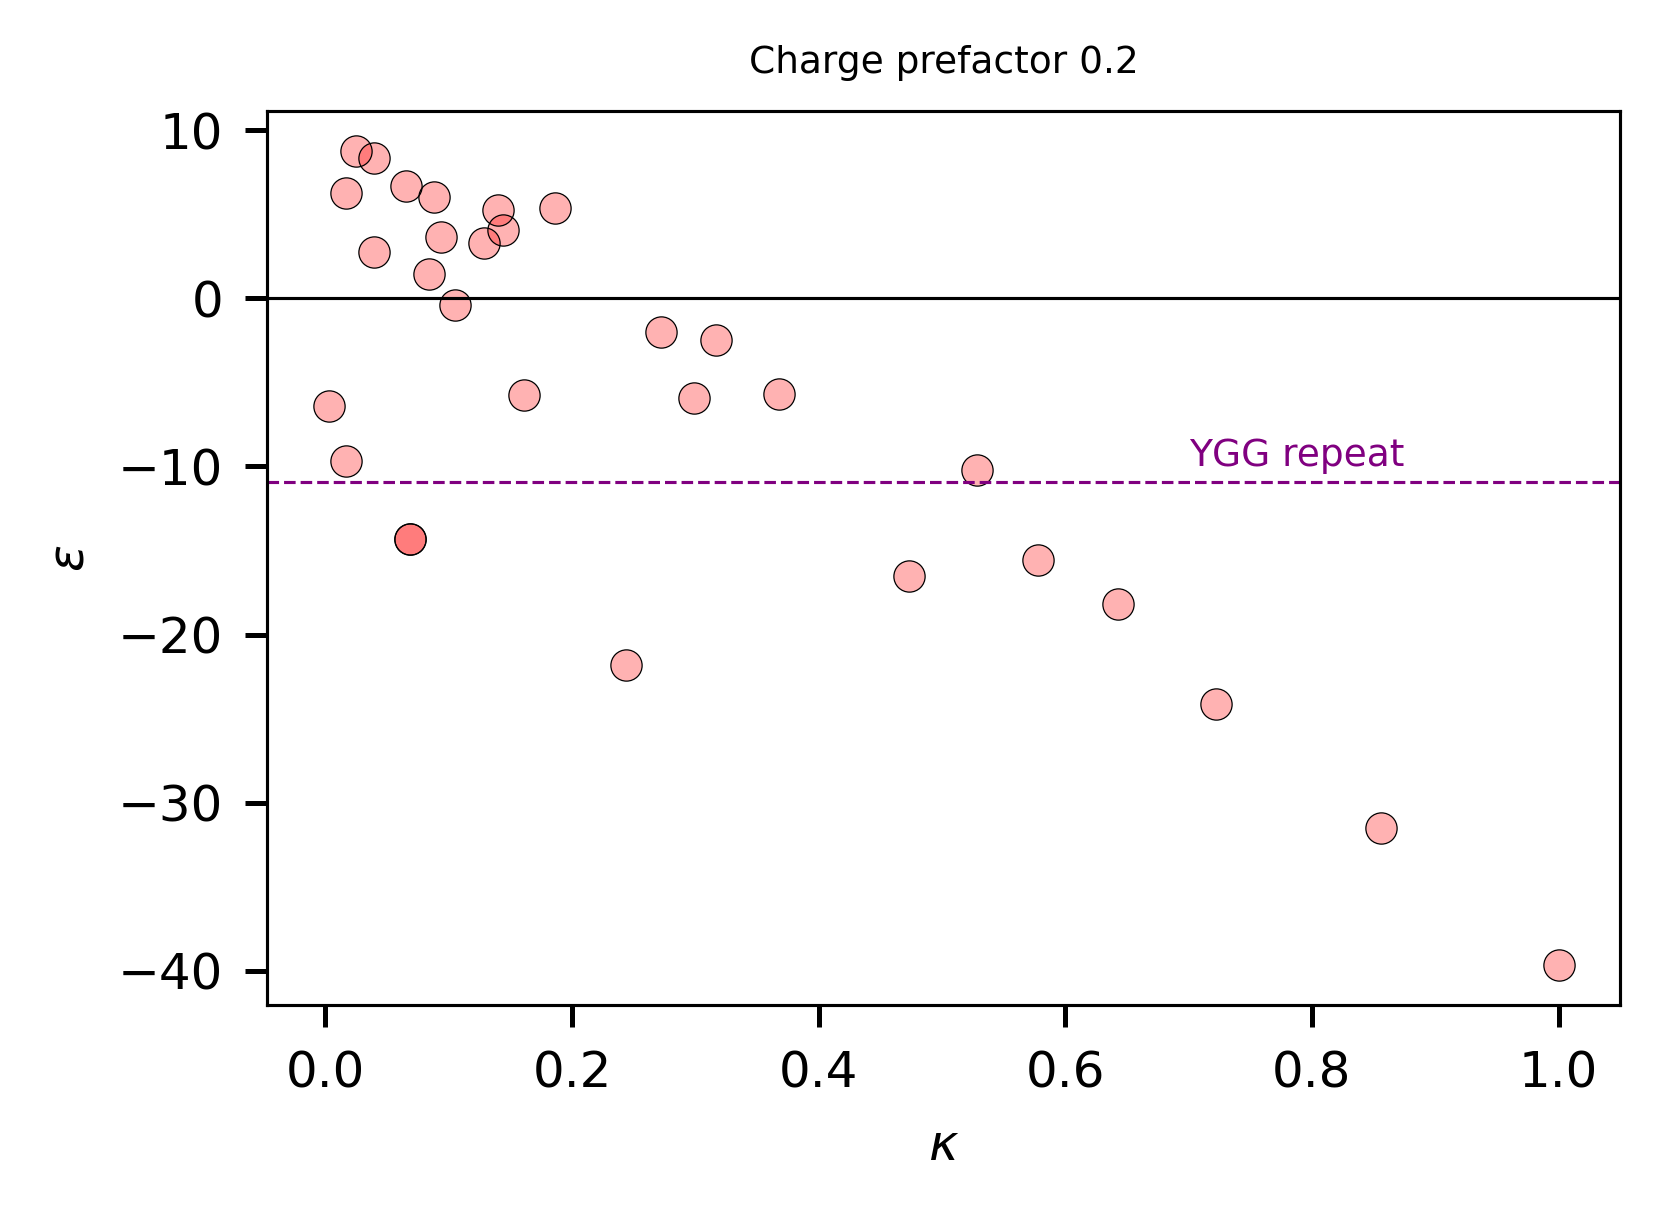

In [7]:
# First calibrate charge prefactor for Mpipi

# default value
mf_cw = 0.2
local_eps_mf = []
for s in seqs:    
    local_eps_mf.append(epsilon_stateless.get_sequence_epsilon_value(s, s,  X=X_model_mf_nosalt, charge_prefactor=mf_cw, use_charge_weighting=True, use_aliphatic_weighting=False))
    
ygg_repeat = 'YGGYGGYGGYGGYGGYGGYGGYGGYGGYGGYGGYGGYGGYGGYGGYGGYGG'
comparison = epsilon_stateless.get_sequence_epsilon_value(ygg_repeat, ygg_repeat,  X=X_model_mf_nosalt, charge_prefactor=mf_cw, use_charge_weighting=True, use_aliphatic_weighting=False)

fig = plt.figure(figsize=(3.8, 2.8), dpi=450)
ax = plt.gca()

plt.plot(k, local_eps_mf,'or', ms=5, mew=0, alpha=0.3)
plt.plot(k, local_eps_mf,'o', ms=5, mew=0.2, mec='k', mfc='None')

show_names = False

if show_names:
    for idx in range(0,30):
        plt.text(k[idx], local_eps_mf[idx], f'{names[idx]}', fontsize=3)

ax.axhline(comparison, lw=0.5, color='purple',ls='--')
ax.axhline(0, lw=0.5, color='k',ls='-')
#plt.ylim([-90,20])
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.ylabel(r'$\epsilon$',fontsize=8)
plt.xlabel(r'$\kappa$',fontsize=8)
plt.text(0.7,-10,'YGG repeat',color='purple', fontsize=6)
plt.title(f'Charge prefactor {mf_cw}', fontsize=6)
plt.tight_layout()
plt.savefig('mpipi_prefactor_determination.pdf')

In [8]:
# compute average ratio between an mpipi and calvados res-res epsilon
all_ratios = []
for aa1 in VALID_AMINO_ACIDS:
    for aa2 in VALID_AMINO_ACIDS:
        p1 = X_model_cf.parameters.compute_interaction_parameter(aa1,aa2)[0]
        p2 = X_model_mf.parameters.compute_interaction_parameter(aa1,aa2)[0]

        all_ratios.append(p1/p2)
        

mean_ratio = np.mean(all_ratios)
print(f"On average, CALVADOS res-res epsilon values are {mean_ratio} times larger than Mpipi params")

On average, CALVADOS res-res epsilon values are 4.390111356247359 times larger than Mpipi params


In [9]:
gradient = []
charge_prefactor_vals = np.arange(0,0.9,0.01)

mf_cw = 0.2
for cf_cw in np.arange(0,0.9,0.01):

    local_eps_cf = []
    local_eps_mf = []

    for s in seqs:
        local_eps_cf.append(epsilon_stateless.get_sequence_epsilon_value(s, s,  X=X_model_cf_nosalt, charge_prefactor=cf_cw, use_charge_weighting=True, use_aliphatic_weighting=False))
        local_eps_mf.append(mean_ratio*epsilon_stateless.get_sequence_epsilon_value(s, s,  X=X_model_mf_nosalt, charge_prefactor=mf_cw, use_charge_weighting=True, use_aliphatic_weighting=False))

    pfit = np.polyfit(local_eps_mf, local_eps_cf,1)[0]
    gradient.append(pfit)
    

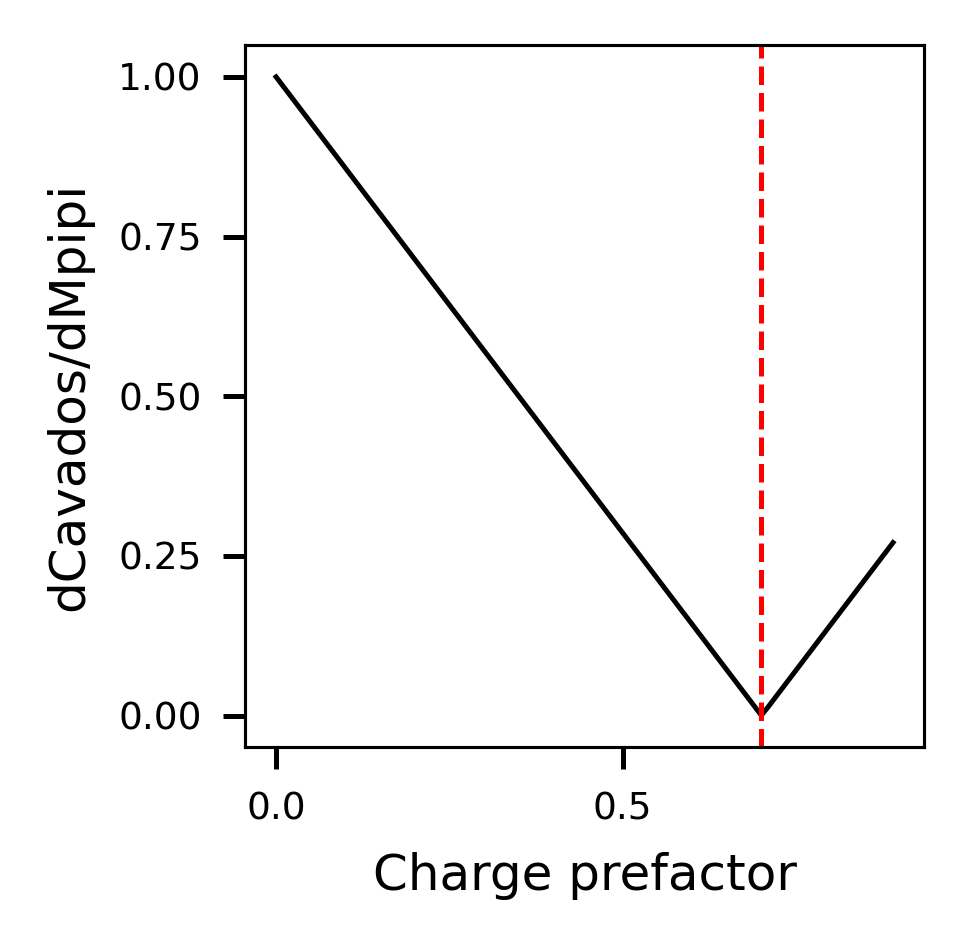

In [10]:
fig = plt.figure(figsize=(2.2, 2.2), dpi=450)
ax = plt.gca()

plt.plot(charge_prefactor_vals,abs(np.array(gradient)-1), color='k',lw=0.8)
ax.axvline(0.7, color='r',ls='--', lw=0.8)
#ax.axvline(0.3)
plt.ylabel('dCavados/dMpipi',fontsize=8)
plt.xlabel('Charge prefactor',fontsize=8)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.tight_layout()
plt.savefig('calvados_prefactor_determination.pdf')

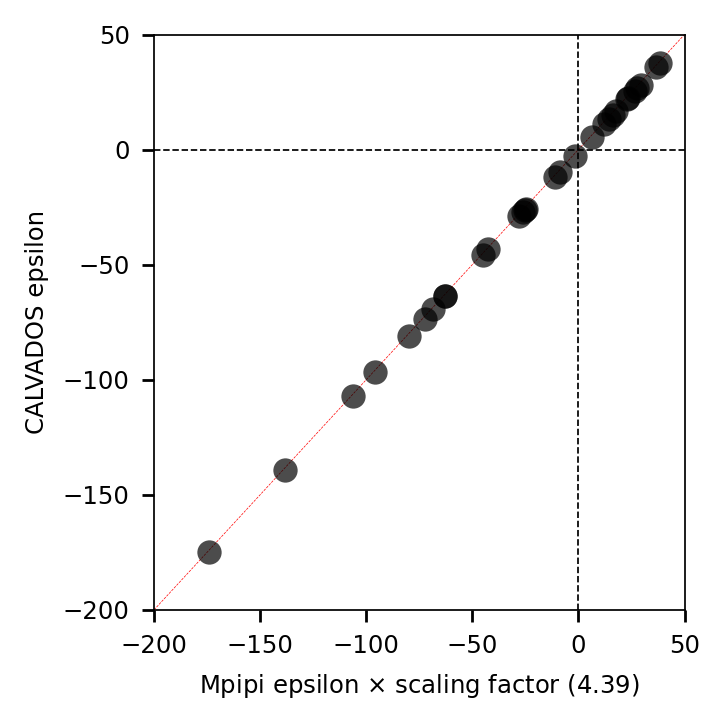

In [45]:
# default charge prefactor used
cf_cw = 0.7
mf_cw = 0.2

local_eps_cf = []
local_eps_mf = []

for s in seqs:
    
    local_eps_cf.append(epsilon_stateless.get_sequence_epsilon_value(s, s,  X=X_model_cf_nosalt, charge_prefactor=cf_cw, use_charge_weighting=True, use_aliphatic_weighting=False))
    local_eps_mf.append(mean_ratio*epsilon_stateless.get_sequence_epsilon_value(s, s,  X=X_model_mf_nosalt, charge_prefactor=mf_cw, use_charge_weighting=True, use_aliphatic_weighting=False))


pfit = np.polyfit(local_eps_mf, local_eps_cf,1)

fig = plt.figure(figsize=(3,3), dpi=250)
plt.plot(local_eps_mf, local_eps_cf,'ok',mew=0, ms=7, alpha=0.7)
ax = plt.gca()
ax.axhline(0,0, color='k',lw=0.5, ls='--')
ax.axvline(0,0, color='k',lw=0.5, ls='--')
plt.xlabel(r'Mpipi epsilon $\times$ scaling factor' + f" ({round(mean_ratio,3)})", fontsize=7)
plt.ylabel('CALVADOS epsilon', fontsize=7)
plt.yticks(fontsize=7)
plt.xticks(fontsize=7)
plt.ylim([-200,50])
plt.xlim([-200,50])
plt.plot([-200,50],[-200,50], '--',color='r', lw=0.2, zorder=-20)
plt.tight_layout()
plt.savefig('mpipi_vs_calvados.pdf')